# EVOLUTIONARY CITY MODEL
## An Agent Based Model
*Put this notebook in the same folder where the virtualenv is created to avoid dependency conflicts.*

### Model Description 

* The model uses a payoff function of the form $$Ern  - cn^2$$, 
    - $E$ is Shannon Entropy within a cell. We use the following discretized form with agents divided into $g$ number of groups       based on their ability levels. $$E = -\sum_{i=1}^{i=g}p_i\log_ep_i, \text{where } p_i=\frac{\text{No. of occurences of agent of Type i in a cell}}{\text{No. of agents in the city/cell}}$$ 
    - $r$ is the ability of an agent where $r\in(0,1)$ and drawn from a uniform distribution.
    - The ability level domain is divided into $g$ equal intervals with size $\frac{1}{g}$ and agents are classified as $\text{Type }1$ if $r\in(0,\frac{1}{g})$, $\text{Type }2$ if $r\in(\frac{1}{g},\frac{2}{g})$ and so on. So for $g=4$, an agent with $r=0.66$ is a $\text{Type }3$ agent as $0.66\in(0.5,0.75)$. 
    - $n$ is the number of agents in the cell and $c$ is a constant.

    
* The model space is **20x20** size Multigrid allowing multiple agents to be present in a cell/city.

* Agents use bounded rationality. Each agent is initialized with attribute **radius** which defines the maximum number of cells it considers while making a move. The radius is defined in a way s.t higher ability agents are more mobile than lower ability agents. This is done by having the radius drawn from a scaled beta distribution $\beta(a,b)$ with shape parameters $a=r\text{ , }b=1-r$. So for higher $r$ the distribution is skewed to right meaning a greater chance of having larger values and vice-versa. The scaling factor is 10, which is half of our grid size. The distribution of radius is illustrated below.

* The model takes the total number of agents in all cities *'$N$'*, negative coefficient *'$c$'* and number of skill groups 

*'$g$'* as inputs. The model also takes agent activation schedule as an input to test Random and Simulataneous activation of agents at each step. Pass **activation = 0** for Random Activation and **activation = 1** for Simultaneous Activation.

### Model classes and functions

* All agents are instances of class **Habitant** and the city model is an instance of class **City_Model**. 

* **shannon_E** is a global function that returns the entropy of a cell. 


* There are 5 model level data collectors-
  - **city_sizes** -  returns an array corresponding to model grid containing the number of agents in each cell.   
  - **city_ranks** - returns a list of tuples. Each tuple contains the cell coordinates and its rank.
  - **model_entropy** - returns a list of lists. Each sublist contains the cell coordinates and its entropy.
  - **model_utility** - returns utility of the entire model which is simply sum of individual agent utilities.
  - **skill_levels** - returns a sorted dictionary with agent types as values and city sizes as keys. Cities of same sizes are merged. 


* At each model step, the agents calculate the payoff before moving into one of their neighboring cells. If the utiltiy is higher than the agent's current cell, it makes a move otherwise stays put in his current cell.

In [612]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import random
import numpy as np
import math
import time
import collections
import operator
from IPython.display import clear_output
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter
from mesa.batchrunner import BatchRunner
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.ticker as ticker
import scipy.stats as st
from scipy.stats import norm

### Distribution of radius for different skill levels

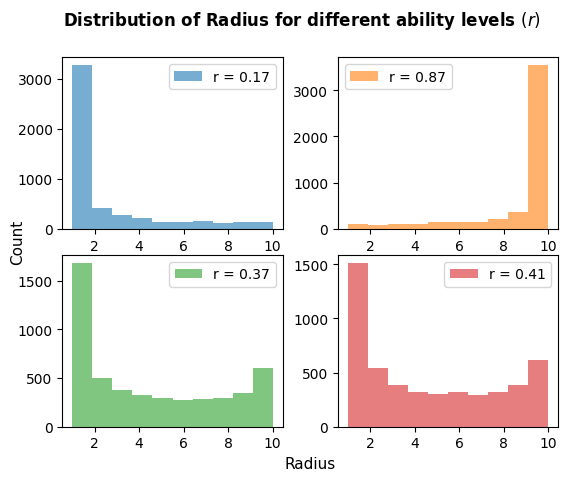

In [673]:
r_list = [np.random.uniform() for x in range(4)]
radius_list = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for r in r_list:
    temp_list = []
    for j in range(5000):
        temp_list.append(math.ceil(np.random.beta(r,(1-r)) * 10))
    radius_list.append(temp_list)
    
fig ,axs = plt.subplots(2,2) 
axs = axs.ravel()
for i ,r in enumerate(r_list):
    axs[i].hist(radius_list[i],alpha=0.6,label='r = {:.2f}'.format(r), color=colors[i])
    axs[i].legend(loc='best')
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Radius",fontsize=11)
plt.ylabel("Count",fontsize=11)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
fig.suptitle(r'Distribution of Radius for different ability levels $(r)$',fontweight='bold',fontsize=12)

plt.show() 

### Model and Agent Classes with model reporters

In [654]:
'''Function to calculate Entropies'''
def shanon_E(type_list):
    occurences = collections.Counter(type_list)
    n = sum(occurences.values())
    entropy = 0
    for i in occurences:
        p = occurences[i]/n
        entropy += -p * math.log(p)
        
    return entropy

'''Model Reporters'''
def city_sizes(model):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    return agent_counts

def city_ranks(model):   
    ranklist = []
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        ranklist.append(((x,y),len(cell_content)))
        
    ranklist.sort(key=operator.itemgetter(1), reverse=True)
    return ranklist

def skill_levels(model):
        skill_dict = {}
        for cell in model.grid.coord_iter():
            cell_content, x, y = cell
            key = "Citysize {}".format(len(cell_content))
            if key in skill_dict:
                for agent in cell_content:
                    skill_dict[key].append(agent.type)
            else:
                type_list = []
                for agent in cell_content:
                    type_list.append(agent.type)
                skill_dict[key] = type_list

        return collections.OrderedDict(sorted(skill_dict.items(), key=lambda x: chr(int(x[0][9:])), reverse = True))
        #return skill_dict
        
def model_utility(model):
    agent_utility = [agent.utility(agent.pos) for agent in model.schedule.agents]
    return sum(agent_utility)
    

def model_entropy(model):
    entropy_list = []
    for cell in model.grid.coord_iter():
        cell_agents, x, y = cell
        type_list = []
        if len(cell_agents) == 0:
            entropy_list.append([(x,y), 0])
            
        else:
            for agent in cell_agents:
                type_list.append(agent.type)

            entropy_list.append([(x,y), shanon_E(type_list)])

    return entropy_list
    
'''Agent Class'''
class Habitant(Agent):
    
    def __init__(self, unique_id, model, agent_ability):
        super().__init__(unique_id, model)
        self.r = agent_ability
        self.radius = math.ceil(np.random.beta(self.r,(1-self.r)) * 10)    # fixed grid size of 20 
        self.type = None

        for i in range(len(self.model.skill_levels)):
            if self.model.skill_levels[i]< self.r <= self.model.skill_levels[i+1]:
                self.type = "Type {}".format(i+1)
           
        self.steps = 0
        self.no_moves = 0
        
    def utility(self, coord):
                
        tot_agents = self.model.grid.get_cell_list_contents(coord)
        n = len(tot_agents)
        agent_type_list = [agent.type for agent in tot_agents]
                
        # check utility for current cell or neighbouring cell        
        if coord != self.pos:
            # +1 term if the agent considers neighbouring cell
            agent_type_list.append(self.type)
            return (shanon_E(agent_type_list) * self.r * (n + 1))  - (self.model.c * (n + 1)**2)  
        else:
            # utility stays the same if agent stays put in current cell

            return (shanon_E(agent_type_list) * self.r * n) - (self.model.c * n**2)    
        
    
    def move(self):
        
        neighbor_cell_pos = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False, radius=self.radius)
        cell_dict = {}     # define a cell dictionary = {keys = (coordinates): values = utility}
        max_pos = None
        
        for n in neighbor_cell_pos:     
            cell_dict[n] = self.utility(n)
            
            MaxValue = max(cell_dict.items(), key=lambda x: x[1])    
            # get the coordinates of maximum utility 
            listcoords = []
            # Iterate over all the items in dictionary to find keys with max value
            for coord, util in cell_dict.items():
                if util == MaxValue[1]:
                    listcoords.append(coord)
                    
            max_pos = random.choice(listcoords)  # make a random choice if multiple cells have same utility
            # move only when moving gives a utility benefit
            if self.utility(max_pos) > self.utility(self.pos):
                self.model.grid.move_agent(self, max_pos)
                
            else: self.no_moves += 1
                          
    def step(self):
        # for RandomActivation
        if self.model.act == 0:
            self.move()
        elif self.model.act == 1:
            self.steps += 1
    
    # for SimultaneousActivation
    def advance(self):    
        self.move()
        
'''Model Class'''
class City_Model(Model):
    """Note the default model parameters"""
    def __init__(self, height = 20, width = 20, N = 1000, neg_coff = 0.01, activation = 0, num_groups=2):
        assert activation in [0,1], 'Activation should be "0 or 1". O for Random , 1 for Simultaneous'
        self.height = height
        self.width = width
        self.num_agents = N
        self.c = neg_coff
        #self.k = pos_coff
        self.act = activation
        self.g = num_groups
        self.skill_levels = np.linspace(0, 1, self.g+1).tolist()
        
        if self.act == 0:
            self.schedule = RandomActivation(self)
        elif self.act == 1:
            self.schedule = SimultaneousActivation(self) 
        
        self.grid = MultiGrid(width, height, True)
        self.running = True
        #Create agents with some ability
        for i in range(self.num_agents):
            agent_ability = np.random.uniform()
            agent = Habitant(i, self, agent_ability)
            self.schedule.add(agent)
    
            # Add the agent to random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x,y))
            
        self.datacollector = DataCollector(model_reporters = {"City_sizes": city_sizes, 
                                                              "Entropy": model_entropy,
                                                             "Ranks": city_ranks,
                                                             "Utility": model_utility,
                                                             "Skill_dist": skill_levels}) 
      
    def step(self):
        """Advance the model by one step"""
        self.datacollector.collect(self) 
        self.schedule.step()

### Define a function that plots Citysizes vs Agent-types 

In [609]:
def bar_plot(ax, model_instance, a_dict , total_width=0.8, single_width=1):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.
        
    model_instance : an instance of City_Model

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the Citysizes and 
        the values are a list of counts in each skill-group. 

        Example:
        dict = {
            "Citysize 20":[1,2,3],
            "Citysize 15":[4,5,6],
            "Citysize 10":[7,8,9],
        }
        Citysize 15 has Type 1 = 4, Type 2 = 5 , Type 3 = 6 

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    """
    default_counter = collections.Counter()
    data = {}
    for i in range(model_instance.g):
        default_counter["Type {}".format(i+1)] = 0 
    for i in a_dict:
        A = collections.Counter(a_dict[i])
        A.update(default_counter)
        data[i] =  list(collections.OrderedDict(sorted(A.items())).values())
        
    # remove citysizes with 0 population    
    data.pop("Citysize 0")
    
    colors = ['xkcd:bright purple','xkcd:green','xkcd:blue', 'xkcd:pink','xkcd:brown','xkcd:red','xkcd:light blue',
            'xkcd:yellow','xkcd:grey','xkcd:lavender','xkcd:tan','xkcd:black','xkcd:lime','xkcd:aqua','xkcd:orange',
            'xkcd:peach','xkcd:fuchsia','xkcd:butter', 'xkcd:green yellow', 'xkcd:light seafoam green','xkcd:light rose',
            'xkcd:bright aqua','xkcd:light olive','xkcd:greyish blue','xkcd:pinkish','xkcd:light turquoise','xkcd:goldenrod',
            'xkcd:cobalt blue','xkcd:dusty blue','xkcd:ice','xkcd:light khaki','xkcd:fresh green','xkcd:cloudy blue',
            'xkcd:leather','xkcd:muted pink','xkcd:light peach','xkcd:hospital green','xkcd:greyish pink','xkcd:perrywinkle']
    
     # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
    

    # Set ticks & legend  
    ax.legend(bars, data.keys(),loc='best', fontsize=6, ncol=2,handleheight=1, labelspacing=0.05)
    ax.set_xticks(range(model_instance.g))
    label =[]
    for i in range(model_instance.g):
        label.append('Type {}\nr'r'$\in$''({:.2f} , {:.2f})'.format(i+1, model_instance.skill_levels[i], model_instance.skill_levels[i+1]))
    ax.set_xticklabels(label, fontsize=8)
    ax.grid(ls='--', lw=0.5, axis='y', color='k')
    ax.set_xlabel("Agent types", fontsize=12)
    ax.set_ylabel("Counts",fontsize=12)
    ax.patch.set_facecolor('xkcd:silver')
    ax.patch.set_alpha(0.5)
    plt.show()

### Run a test model and collect data

In [468]:
test_model = City_Model(N=2000, num_groups=3) 
STEPS = 20
for i in range(STEPS): # run model for some steps
    test_model.step()
    
city_evolution = test_model.datacollector.get_model_vars_dataframe()

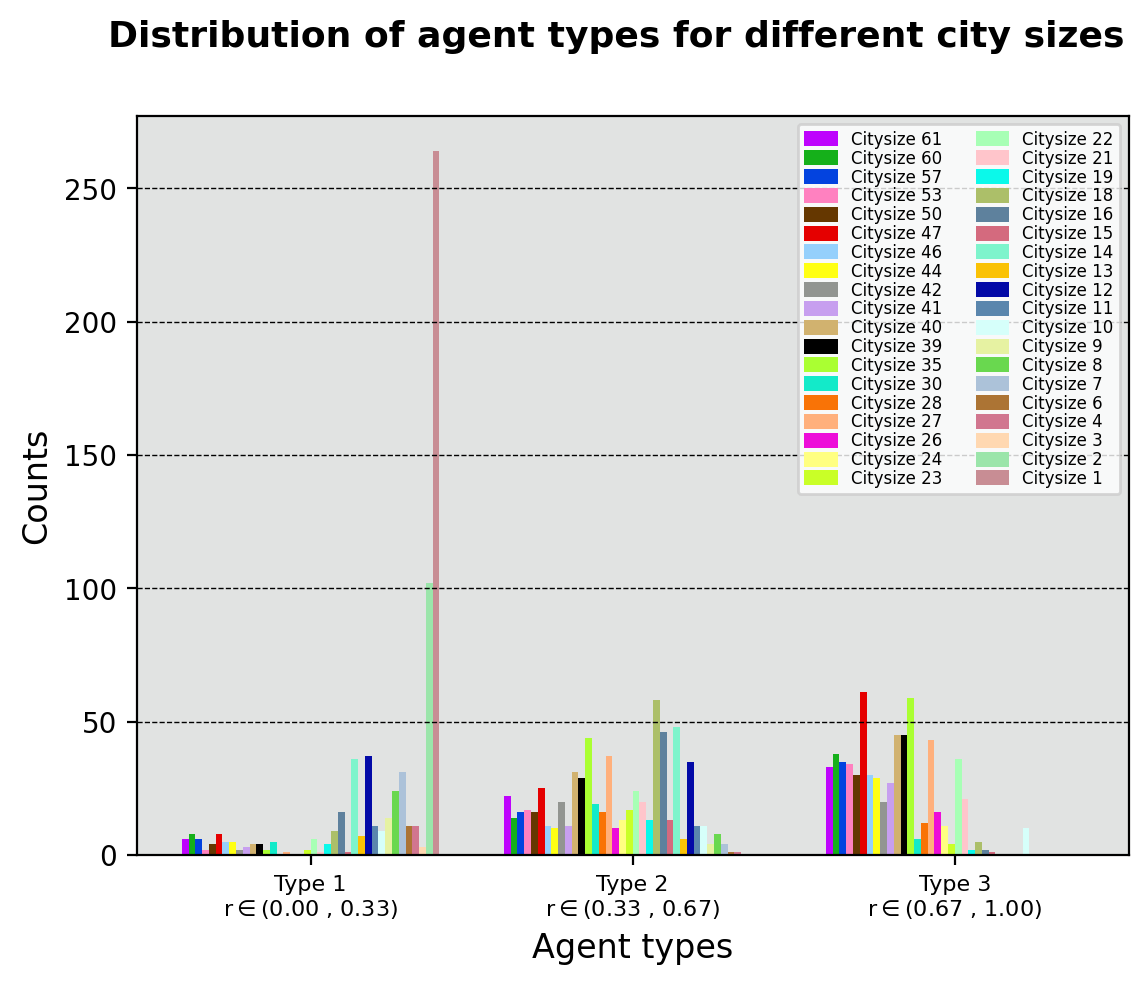

In [610]:
##collect data at last step 
plot_dict = city_evolution["Skill_dist"].iloc[STEPS-1]
fig, ax = plt.subplots(dpi=200)
fig.suptitle("Distribution of agent types for different city sizes",fontsize=13,fontweight='bold')
bar_plot(ax=ax, model_instance= test_model, a_dict= plot_dict)

### Visualize city sizes at each step

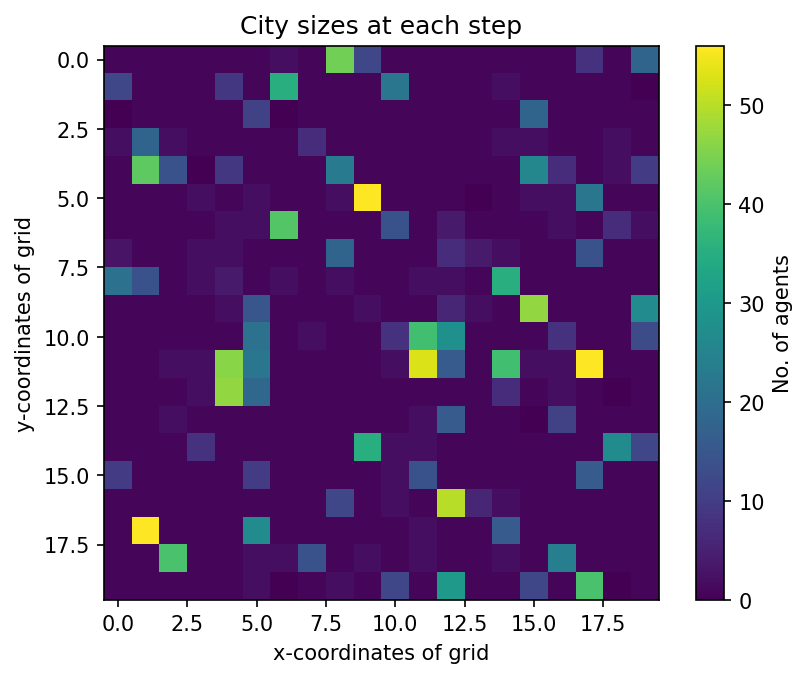

In [655]:
## Plot city sizes over time. 
MIN = min(min(min(x.tolist()) for x in city_evolution["City_sizes"]))
MAX = max(max(max(x.tolist()) for x in city_evolution["City_sizes"]))

for i in range(STEPS):
    fig = plt.figure(dpi=150)
    plt.imshow(city_evolution["City_sizes"][i])
    plt.title("City sizes at each step")
    plt.xlabel("x-coordinates of grid")
    plt.ylabel("y-coordinates of grid")
    plt.colorbar(label="No. of agents")
    plt.clim(MIN, MAX)
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Plot overall model utitlites at each step

<AxesSubplot:title={'center':'Model Utilities at each step'}, xlabel='steps', ylabel='utility'>

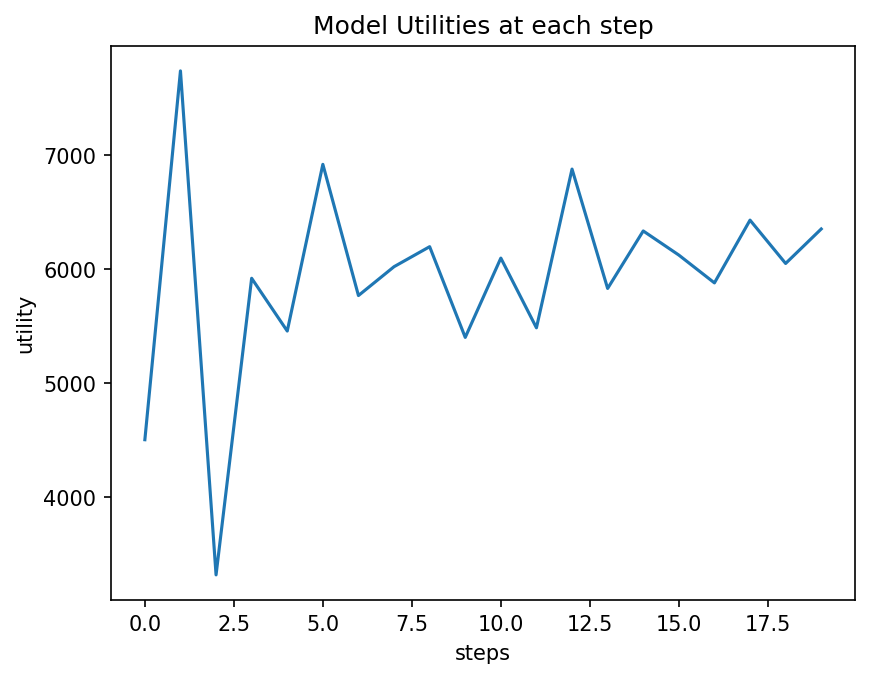

In [656]:
fig = plt.figure(dpi=150)
city_evolution["Utility"].plot(xlabel="steps", ylabel="utility",title="Model Utilities at each step")

### Visualize city rank - size distribution of cities(cells) at each step

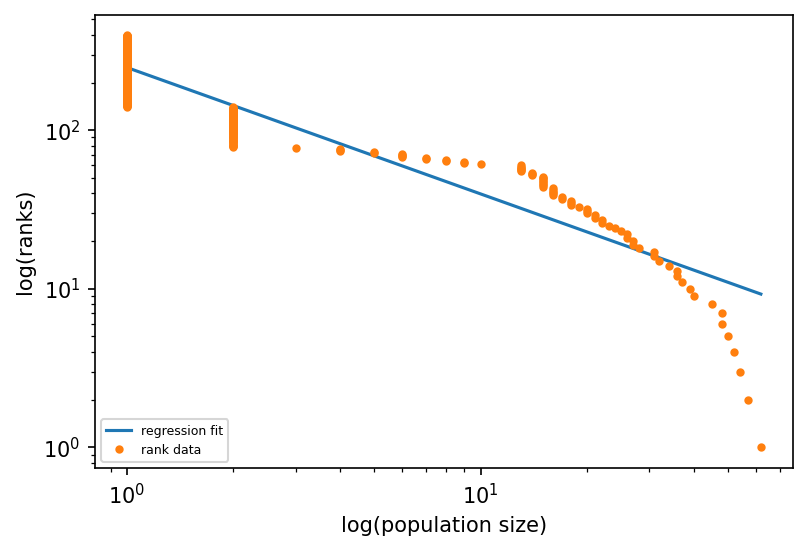

In [203]:
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

for i in range(STEPS):
    ranklist = city_evolution.iloc[i]["Ranks"]
    n = len(ranklist)
    ranks = range(1, n+1)                        # y-axis: log(the ranks)
    pops = [pops for (coords, pops) in ranklist] # x-axis: log(the poplution size)
    ## Remove 0's to avoid log(0)
    if 0 in pops:
        idx = pops.index(0)
        pops = pops[:idx]
        ranks = ranks[:idx]
        
    # regression
    ys = powerfit(pops, ranks, pops)
    fig = plt.figure(dpi=150)
    plt.plot(pops, ys, label='regression fit')
    plt.loglog(pops, ranks, '.', label='rank data')

    plt.xlabel('log(population size)')
    plt.ylabel('log(ranks)')
    plt.legend(loc='lower left',prop={'size': 6})
    plt.show()
    time.sleep(0.2)
    clear_output(wait=True)  

### See entropy distribution of cities at the end of each Model run. 

**Visualise entropy distribution at each step**

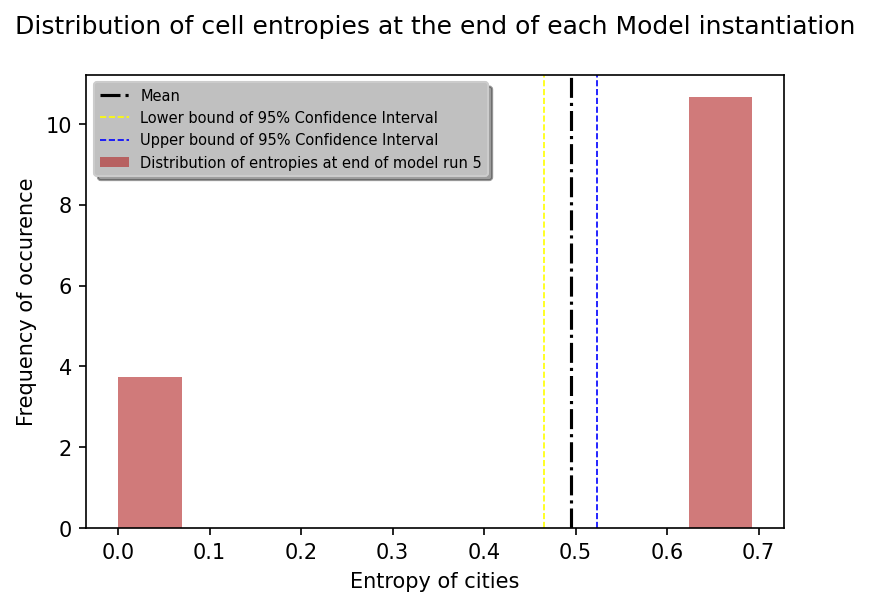

In [46]:
for i in range(5):                       # iterate the model 5 times
    model = city_model()                 # default params used
    for j in range(STEPS):                  # run each model for 20 steps
        model.step()
    city_evolution = model.datacollector.get_model_vars_dataframe()    
    eList = []
    for j in city_evolution.iloc[STEPS-1]["Entropy"]:   # check the entropies at end of model run
        eList.append(j[1])   
    intv95 = st.norm.interval(alpha=0.95, loc=np.mean(eList), scale=st.sem(eList))
    # Plot the histogram.
    fig = plt.figure(dpi=150)
    plt.hist(eList, bins= "auto", density=True,color='firebrick',alpha=0.6, 
             label="Distribution of entropies at end of model run {}".format(i+1))
    plt.axvline(x=np.mean(eList), color='k', linestyle='dashdot', label="Mean")
    plt.axvline(x=intv95[0],color='yellow',linestyle='--',linewidth=0.8,label='Lower bound of 95% Confidence Interval')
    plt.axvline(x=intv95[1],color='blue',linestyle='--',linewidth=0.8,label='Upper bound of 95% Confidence Interval')
    plt.xlabel('Entropy of cities')
    plt.ylabel('Frequency of occurence')
    plt.title("Distribution of cell entropies at the end of each Model iteration",pad=20)
    plt.legend(loc='best', shadow=True, prop={'size': 7}, facecolor="silver")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Server

In [44]:
def city_draw(agent):
    """
    Portrayal Method for canvas
    """
    if agent.type == 'L':  # red for L
        portrayal = {"Shape": "rect","w": 0.2,"h":0.2, "Color": "red","Filled": "false","Layer":0 }
    else:                  # green for H
        portrayal = {"Shape": "circle","r": 0.5, "Color": "green","Filled": "true","Layer":1 }
            
    return portrayal

grid = CanvasGrid(city_draw, 20, 20, 500, 500)
chart = ChartModule([{"Label": "Utility",
                      "Color": "Black"}],
                    data_collector_name='datacollector')
model_params = {
    "height": 20,
    "width": 20,
    "N": UserSettableParameter("slider", "Number of Agents", 1000, 500, 2500, 500),
    "neg_coff": UserSettableParameter("slider", "Negative coefficient(c)", 0.1, 0.05, 0.25, 0.05),
    "pos_coff": UserSettableParameter("slider", "Positive Coefficeint(k)", 1, 0.5, 2, 0.25),
    "activation": UserSettableParameter("slider", "0 for Random, 1 for Simulatneous", 0, 0, 1, 1)}

server = ModularServer(city_model, [grid, chart], "City Model", model_params)
server.launch()

Interface starting at http://127.0.0.1:8521


OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted

### Parameter sweep for negative coefficient $c$ in $[5^{-1},5^{-2},5^{-3},5^{-4}]$ using 10 model iterations. Each model has maximum 30 steps

In [119]:
fixed_params = {"N": 5000,"width": 20,
               "height": 20, "num_groups": 2, "activation": 0}
variable_params = {"neg_coff": [5**-1, 5**-2, 5**-3, 5**-4]}

batch_run1 = BatchRunner(city_model,
                        variable_params,
                        fixed_params,
                        iterations = 10,
                        max_steps = 30,
                        model_reporters={"Entropy": model_entropy, "Ranks": city_ranks})
batch_run1.run_all()

40it [19:31:34, 1757.36s/it]


In [312]:
run_data = batch_run1.get_model_vars_dataframe()
run_data.head()

,neg_coff,Run,Entropy,Ranks,N,width,height,pos_coff,activation
0,0.2,0,"[[(0, 0), 0.6901856760188042], [(0, 1), 0.6901...","[((0, 0), 13), ((0, 1), 13), ((0, 4), 13), ((0...",5000,20,20,1,0
1,0.2,1,"[[(0, 0), 0.6901856760188042], [(0, 1), 0.6931...","[((0, 0), 13), ((0, 2), 13), ((0, 4), 13), ((0...",5000,20,20,1,0
2,0.2,2,"[[(0, 0), 0.6901856760188042], [(0, 1), 0.6365...","[((0, 0), 13), ((0, 4), 13), ((0, 5), 13), ((0...",5000,20,20,1,0
3,0.2,3,"[[(0, 0), 0.6901856760188042], [(0, 1), 0.6901...","[((0, 0), 13), ((0, 1), 13), ((0, 2), 13), ((0...",5000,20,20,1,0
4,0.2,4,"[[(0, 0), 0.6901856760188042], [(0, 1), 0.6901...","[((0, 0), 13), ((0, 1), 13), ((0, 4), 13), ((0...",5000,20,20,1,0


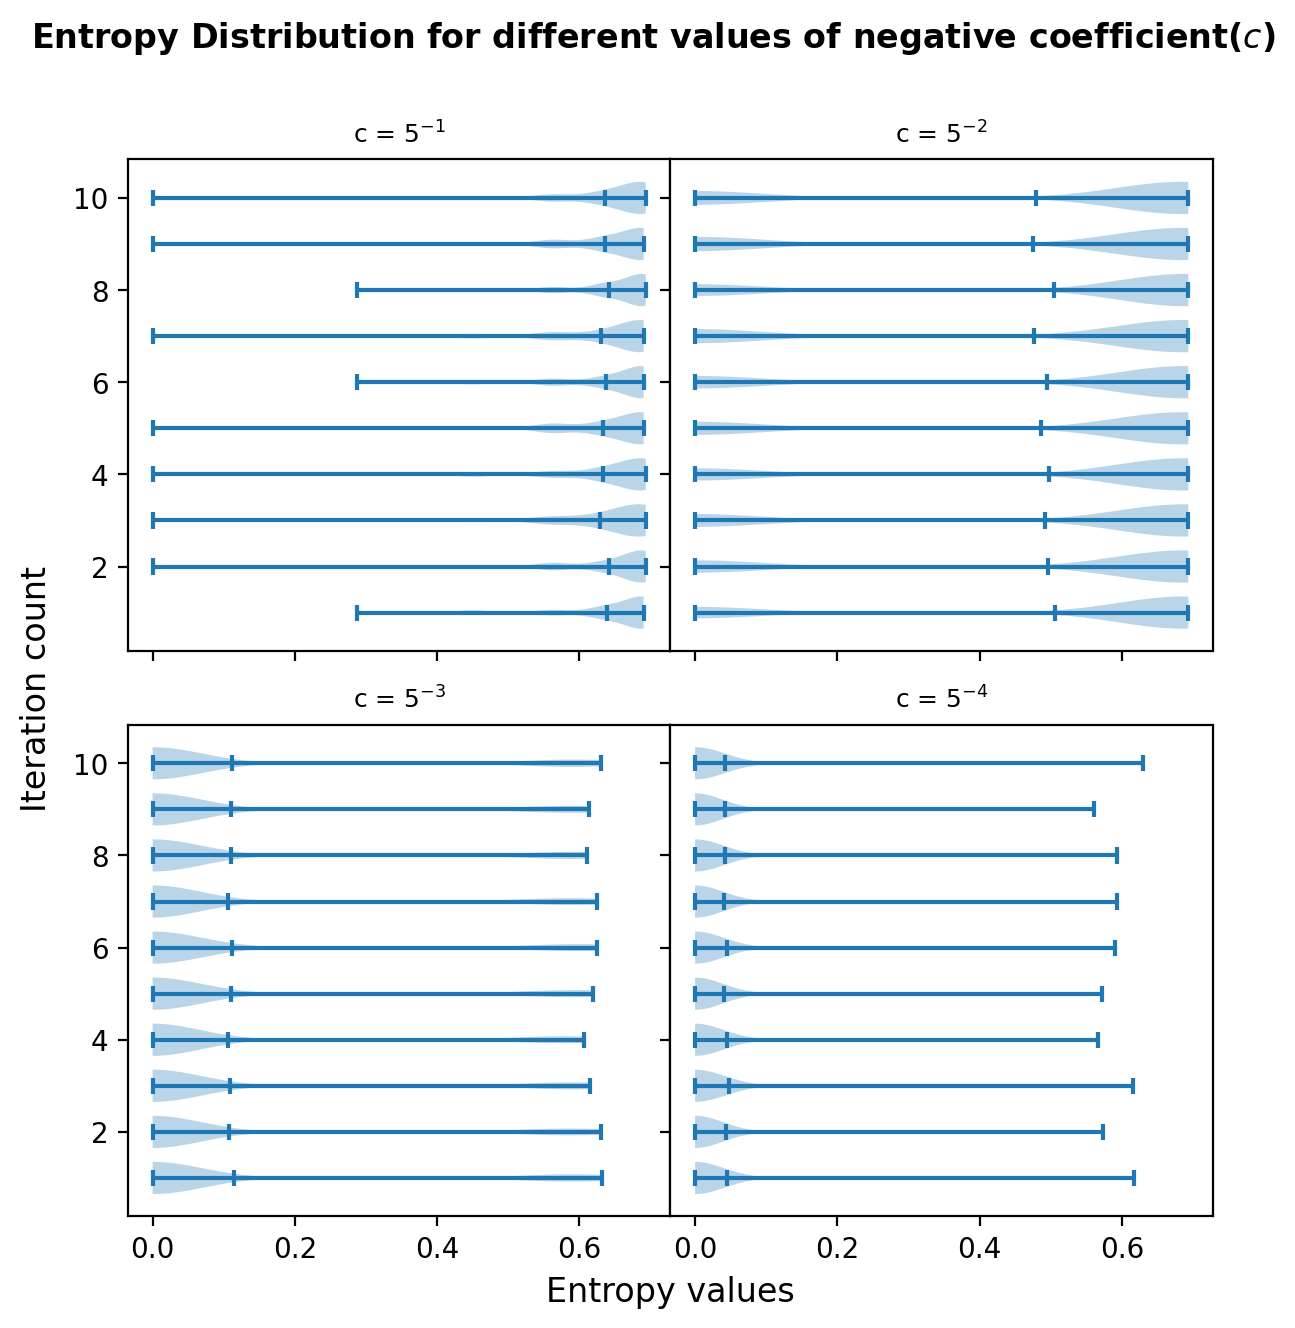

In [320]:
run_data = batch_run1.get_model_vars_dataframe()

entropy_c1 = []; entropy_c2 = []; entropy_c3 = []; entropy_c4 = [] 
for i in run_data.iloc[0:10]["Entropy"]:
    temp = []
    for j in i:      
        temp.append(j[1])
    entropy_c1.append(temp)
    
    
for i in run_data.iloc[10:20]["Entropy"]:
    temp = []
    for j in i:
        temp.append(j[1])
    entropy_c2.append(temp)
    
for i in run_data.iloc[20:30]["Entropy"]:
    temp = []
    for j in i:
        temp.append(j[1])
    entropy_c3.append(temp)
    
for i in run_data.iloc[30:40]["Entropy"]:
    temp = []
    for j in i:
        temp.append(j[1])
    entropy_c4.append(temp)    
    
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(7,7),dpi=200)
(ax1, ax2), (ax3, ax4) = axs

ax1.violinplot(entropy_c1, vert=False, showmeans=True, widths=0.7)
ax1.set_title(r'c = $5^{-1}$',fontsize=9)


ax2.violinplot(entropy_c2, vert=False, showmeans=True, widths=0.7)
ax2.set_title(r'c = $5^{-2}$',fontsize=9)

ax3.violinplot(entropy_c3, vert=False, showmeans=True, widths=0.7)
ax3.set_title(r'c = $5^{-3}$',fontsize=9)

ax4.violinplot(entropy_c4, vert=False, showmeans=True, widths=0.7)
ax4.set_title(r'c = $5^{-4}$',fontsize=9)


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Entropy values",fontsize=12)
plt.ylabel("Iteration count",fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.15)
fig.suptitle(r'Entropy Distribution for different values of negative coefficient($c$)',fontweight='bold',fontsize=12)

plt.show()   

## Analysis using SALib

In [318]:
problem = {
    'num_vars': 3,
    'names': ['neg_coff', 'pos_coff', 'N'],
    'bounds': [[0.0001, 1], [1, 10], [5000, 100000]]
}
model_reporters = {"Entropy": model_entropy, "Sizes": city_sizes, "Utility": model_utility}

### OFAT

In [314]:

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 30
max_steps = 100
distinct_samples = 30 

data = {}

for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num = distinct_samples)
    
    # N should be integers. sample in such a way that we only get integers.
    if var == 'N':
        samples = np.linspace(*problem['bounds'][i], num = distinct_samples, dtype=int)
    
    batch = BatchRunner(city_model, 
                        max_steps= max_steps,
                        iterations= replicates,
                        variable_parameters= {var: samples},
                        model_reporters= model_reporters,
                        display_progress= True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()

0it [05:01, ?it/s]


KeyboardInterrupt: 

### SOBOL

In [319]:
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 10
max_steps = 100
distinct_samples = 10

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

# READ NOTE BELOW CODE
batch = BatchRunner(city_model, 
                    max_steps =max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['neg_coff', 'pos_coff', 'N'])
data['Run'], data['Entropy'], data['Sizes'], data['Utility'] = None, None, None, None

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[2] = int(vals[2])
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled
        data.iloc[count, 0:3] = vals
        data.iloc[count, 3:7] = iteration_data
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

KeyboardInterrupt: 